### In this notebook I want to do a similar analysis to that of [Trinquier, Weigt](https://pubmed.ncbi.nlm.nih.gov/34608136/). We hence want to plot the projection onto the first two PCA components of the true MSAs for samples generated respectively from the ESM model and out Potts Decoder.

In [1]:
import torch
import numpy as np
import scipy
import os
import sys
import biotite.structure
from biotite.structure.io import pdbx, pdb
from biotite.structure.residues import get_residues
from biotite.structure import filter_backbone
from biotite.structure import get_chains
from biotite.sequence import ProteinSequence
from typing import Sequence, Tuple, List
from Bio import SeqIO


git_folder = '/home/luchinoprince/Dropbox/Old_OneDrive/Phd/Second_year/research/Feinauer/Inverse_Folding'
esm_folder = '/home/luchinoprince/Dropbox/Old_OneDrive/Phd/Second_year/research/Feinauer/esm/'
sys.path.insert(1, os.path.join(git_folder, 'model'))
sys.path.insert(1, os.path.join(git_folder, 'util'))

sys.path.insert(1, esm_folder)
import esm
#from esm.inverse_folding import util
import esm.pretrained as pretrained

## I import this to try to get deeper on the sampling perplexity
#from esm.inverse_folding.features import DihedralFeatures
#from esm.inverse_folding.gvp_encoder import GVPEncoder
#from esm.inverse_folding.gvp_utils import unflatten_graph
#from esm.inverse_folding.gvp_transformer_encoder import GVPTransformerEncoder
#from esm.inverse_folding.transformer_decoder import TransformerDecoder
#from esm.inverse_folding.util import rotate, CoordBatchConverter 


#### Code for model with PLL ########
#from potts_decoder import PottsDecoder
#### Code for model with NCE ##########
from potts_decoder import PottsDecoder
from ioutils import read_fasta, read_encodings

from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F
from torch.nn.functional import one_hot

from collections import defaultdict

import matplotlib.pyplot as plt



In [2]:
class BatchConverter(object):
    """Callable to convert an unprocessed (labels + strings) batch to a
    processed (labels + tensor) batch.
    """

    def __init__(self, alphabet, truncation_seq_length: int = None):
        self.alphabet = alphabet
        self.truncation_seq_length = truncation_seq_length

    def __call__(self, raw_batch: Sequence[Tuple[str, str]]):
        # RoBERTa uses an eos token, while ESM-1 does not.
        batch_size = len(raw_batch)
        batch_labels, seq_str_list = zip(*raw_batch)
        seq_encoded_list = [self.alphabet.encode(seq_str) for seq_str in seq_str_list]
        if self.truncation_seq_length:
            seq_encoded_list = [seq_str[:self.truncation_seq_length] for seq_str in seq_encoded_list]
        max_len = max(len(seq_encoded) for seq_encoded in seq_encoded_list)
        tokens = torch.empty(
            (
                batch_size,
                max_len + int(self.alphabet.prepend_bos) + int(self.alphabet.append_eos),
            ),
            dtype=torch.int64,
        )
        tokens.fill_(self.alphabet.padding_idx)
        labels = []
        strs = []

        for i, (label, seq_str, seq_encoded) in enumerate(
            zip(batch_labels, seq_str_list, seq_encoded_list)
        ):
            labels.append(label)
            strs.append(seq_str)
            if self.alphabet.prepend_bos:
                tokens[i, 0] = self.alphabet.cls_idx
            seq = torch.tensor(seq_encoded, dtype=torch.int64)
            tokens[
                i,
                int(self.alphabet.prepend_bos) : len(seq_encoded)
                + int(self.alphabet.prepend_bos),
            ] = seq
            if self.alphabet.append_eos:
                tokens[i, len(seq_encoded) + int(self.alphabet.prepend_bos)] = self.alphabet.eos_idx

        return labels, strs, tokens


class CoordBatchConverter(BatchConverter):
    def __call__(self, raw_batch: Sequence[Tuple[Sequence, str]], device=None):
        """
        Args:
            raw_batch: List of tuples (coords, confidence, seq)
            In each tuple,
                coords: list of floats, shape L x 3 x 3
                confidence: list of floats, shape L; or scalar float; or None
                seq: string of length L
        Returns:
            coords: Tensor of shape batch_size x L x 3 x 3
            confidence: Tensor of shape batch_size x L
            strs: list of strings
            tokens: LongTensor of shape batch_size x L
            padding_mask: ByteTensor of shape batch_size x L
        """
        self.alphabet.cls_idx = self.alphabet.get_idx("<cath>") 
        batch = []
        for coords, confidence, seq in raw_batch:
            if confidence is None:
                confidence = 1.
            if isinstance(confidence, float) or isinstance(confidence, int):
                confidence = [float(confidence)] * len(coords)
            if seq is None:
                seq = 'X' * len(coords)
            batch.append(((coords, confidence), seq))

        coords_and_confidence, strs, tokens = super().__call__(batch)

        # pad beginning and end of each protein due to legacy reasons
        coords = [
            F.pad(torch.tensor(cd), (0, 0, 0, 0, 1, 1), value=np.inf)
            for cd, _ in coords_and_confidence
        ]
        confidence = [
            F.pad(torch.tensor(cf), (1, 1), value=-1.)
            for _, cf in coords_and_confidence
        ]
        coords = self.collate_dense_tensors(coords, pad_v=np.nan)
        confidence = self.collate_dense_tensors(confidence, pad_v=-1.)
        if device is not None:
            coords = coords.to(device)
            confidence = confidence.to(device)
            tokens = tokens.to(device)
        padding_mask = torch.isnan(coords[:,:,0,0])
        coord_mask = torch.isfinite(coords.sum(-2).sum(-1))
        confidence = confidence * coord_mask + (-1.) * padding_mask
        return coords, confidence, strs, tokens, padding_mask

    def from_lists(self, coords_list, confidence_list=None, seq_list=None, device=None):
        """
        Args:
            coords_list: list of length batch_size, each item is a list of
            floats in shape L x 3 x 3 to describe a backbone
            confidence_list: one of
                - None, default to highest confidence
                - list of length batch_size, each item is a scalar
                - list of length batch_size, each item is a list of floats of
                    length L to describe the confidence scores for the backbone
                    with values between 0. and 1.
            seq_list: either None or a list of strings
        Returns:
            coords: Tensor of shape batch_size x L x 3 x 3
            confidence: Tensor of shape batch_size x L
            strs: list of strings
            tokens: LongTensor of shape batch_size x L
            padding_mask: ByteTensor of shape batch_size x L
        """
        batch_size = len(coords_list)
        if confidence_list is None:
            confidence_list = [None] * batch_size
        if seq_list is None:
            seq_list = [None] * batch_size
        raw_batch = zip(coords_list, confidence_list, seq_list)
        return self.__call__(raw_batch, device)

    @staticmethod
    def collate_dense_tensors(samples, pad_v):
        """
        Takes a list of tensors with the following dimensions:
            [(d_11,       ...,           d_1K),
             (d_21,       ...,           d_2K),
             ...,
             (d_N1,       ...,           d_NK)]
        and stack + pads them into a single tensor of:
        (N, max_i=1,N { d_i1 }, ..., max_i=1,N {diK})
        """
        if len(samples) == 0:
            return torch.Tensor()
        if len(set(x.dim() for x in samples)) != 1:
            raise RuntimeError(
                f"Samples has varying dimensions: {[x.dim() for x in samples]}"
            )
        (device,) = tuple(set(x.device for x in samples))  # assumes all on same device
        max_shape = [max(lst) for lst in zip(*[x.shape for x in samples])]
        result = torch.empty(
            len(samples), *max_shape, dtype=samples[0].dtype, device=device
        )
        result.fill_(pad_v)
        for i in range(len(samples)):
            result_i = result[i]
            t = samples[i]
            result_i[tuple(slice(0, k) for k in t.shape)] = t
        return result


#########################   UPDATE THIS TO ENHANCE SAMPLING. ###########################################
def sample(self, coords, partial_seq=None, temperature=1.0, confidence=None, device=None):
        """
        Samples sequences based on multinomial sampling (no beam search).

        Args:
            coords: L x 3 x 3 list representing one backbone
            partial_seq: Optional, partial sequence with mask tokens if part of
                the sequence is known
            temperature: sampling temperature, use low temperature for higher
                sequence recovery and high temperature for higher diversity
            confidence: optional length L list of confidence scores for coordinates
        """
        L = len(coords)
        # Convert to batch format
        batch_converter = CoordBatchConverter(self.decoder.dictionary)
        batch_coords, confidence, _, _, padding_mask = (
            batch_converter([(coords, confidence, None)], device=device)
        )
        
        # Start with prepend token
        mask_idx = self.decoder.dictionary.get_idx('<mask>')
        sampled_tokens = torch.full((1, 1+L), mask_idx, dtype=int)
        sampled_tokens[0, 0] = self.decoder.dictionary.get_idx('<cath>')
        if partial_seq is not None:
            for i, c in enumerate(partial_seq):
                sampled_tokens[0, i+1] = self.decoder.dictionary.get_idx(c)
            
        # Save incremental states for faster sampling
        incremental_state = dict()
        
        # Run encoder only once
        encoder_out = self.encoder(batch_coords, padding_mask, confidence)
        
        # Make sure all tensors are on the same device if a GPU is present
        if device:
            sampled_tokens = sampled_tokens.to(device)
        
        # Decode one token at a time
        for i in range(1, L+1):
            logits, _ = self.decoder(
                sampled_tokens[:, :i], 
                encoder_out,
                incremental_state=incremental_state,
            )
            logits = logits[0].transpose(0, 1)
            logits /= temperature
            probs = F.softmax(logits, dim=-1)
            if sampled_tokens[0, i] == mask_idx:
                sampled_tokens[:, i] = torch.multinomial(probs, 1).squeeze(-1)
        sampled_seq = sampled_tokens[0, 1:]
        
        # Convert back to string via lookup
        return ''.join([self.decoder.dictionary.get_tok(a) for a in sampled_seq])
    

In [3]:
def load_structure(fpath, chain=None):
    """
    Args:
        fpath: filepath to either pdb or cif file
        chain: the chain id or list of chain ids to load
    Returns:
        biotite.structure.AtomArray
    """
    with open(fpath) as fin:
        pdbf = pdb.PDBFile.read(fin)
    structure = pdb.get_structure(pdbf, model=1)
    bbmask = filter_backbone(structure)
    structure = structure[bbmask]
    all_chains = get_chains(structure)
    if len(all_chains) == 0:
        raise ValueError('No chains found in the input file.')
    if chain is None:
        chain_ids = all_chains
    elif isinstance(chain, list):
        chain_ids = chain
    else:
        chain_ids = [chain] 
    for chain in chain_ids:
        if chain not in all_chains:
            raise ValueError(f'Chain {chain} not found in input file')
    chain_filter = [a.chain_id in chain_ids for a in structure]
    structure = structure[chain_filter]
    return structure

def extract_coords_from_structure(structure: biotite.structure.AtomArray):
    """
    Args:
        structure: An instance of biotite AtomArray
    Returns:
        Tuple (coords, seq)
            - coords is an L x 3 x 3 array for N, CA, C coordinates
            - seq is the extracted sequence
    """
    coords = get_atom_coords_residuewise(["N", "CA", "C"], structure)
    residue_identities = get_residues(structure)[1]
    seq = ''.join([ProteinSequence.convert_letter_3to1(r) for r in residue_identities])
    return coords, seq

def get_atom_coords_residuewise(atoms: List[str], struct: biotite.structure.AtomArray):
    """
    Example for atoms argument: ["N", "CA", "C"]
    """
    def filterfn(s, axis=None):
        filters = np.stack([s.atom_name == name for name in atoms], axis=1)
        sum = filters.sum(0)
        if not np.all(sum <= np.ones(filters.shape[1])):
            raise RuntimeError("structure has multiple atoms with same name")
        index = filters.argmax(0)
        coords = s[index].coord
        coords[sum == 0] = float("nan")
        return coords

    return biotite.structure.apply_residue_wise(struct, struct, filterfn)

def get_loss_new(decoder, inputs, eta):
    """eta is the multiplicative term in front of the penalized negative pseudo-log-likelihood"""
    msas, encodings, padding_mask  = [input.to(device) for input in inputs]
    B, M, N = msas.shape
    #print(f"encodings' shape{encodings.shape}, padding mask:{padding_mask.shape}")
    param_embeddings, fields = decoder.forward_new(encodings, padding_mask)
    msas_embedded = embedding(msas)

    # get npll
    npll = get_npll2(msas_embedded, param_embeddings, fields, N, q)
    padding_mask_inv = (~padding_mask)
    # multiply with the padding mask to filter non-existing residues (this is probably not necessary)       
    npll = npll * padding_mask_inv.unsqueeze(1)
    npll_mean = torch.sum(npll) / (M * torch.sum(padding_mask_inv))
    
    Q = torch.einsum('bkuia, buhia->bkhia', 
                param_embeddings.unsqueeze(2), param_embeddings.unsqueeze(1)).sum(axis=-1)
    penalty = eta*(torch.sum(torch.sum(Q,axis=-1)**2) - torch.sum(Q**2) + torch.sum(fields**2))/B
    loss_penalty = npll_mean + penalty
    return loss_penalty, npll_mean.item() 

def get_loss(decoder, inputs, eta):
    """eta is the multiplicative term in front of the penalized negative pseudo-log-likelihood"""
    msas, encodings, padding_mask  = [input.to(device) for input in inputs]
    B, M, N = msas.shape
    #print(f"encodings' shape{encodings.shape}, padding mask:{padding_mask.shape}")
    couplings, fields = decoder(encodings, padding_mask)

    # embed and reshape to (B, M, N*q)
    msas_embedded = embedding(msas).view(B, M, -1)

    # get npll
    npll = get_npll(msas_embedded, couplings, fields, N, q)
    padding_mask_inv = (~padding_mask)

    # multiply with the padding mask to filter non-existing residues (this is probably not necessary)       
    npll = npll * padding_mask_inv.unsqueeze(1)
    penalty = eta*(torch.sum(couplings**2) + torch.sum(fields**2))/B

    # the padding mask does not contain the msa dimension so we need to multiply by M
    npll_mean = torch.sum(npll) / (M * torch.sum(padding_mask_inv))
    loss_penalty = npll_mean + penalty
    return loss_penalty, npll_mean.item() 
    #return loss_penalty

def get_loss_loader(decoder, loader, eta):

    decoder.eval()
    losses = 0
    iterator = 0
    with torch.no_grad():
        for inputs in loader:
            iterator+=1
            _, npll = get_loss_new(decoder, inputs, eta) 
            losses+=npll
    
    return losses/iterator

def compute_covariance(msa, q):
    """
    Compute covariance matrix of a given MSA having q different amino acids
    """
    M, N = msa.shape

    # One hot encode classes and reshape to create data matrix
    D = torch.flatten(one_hot(msa, num_classes=q), start_dim=1).to(torch.float32)

    # Remove one amino acid
    D = D.view(M, N, q)[:, :, :q-1].flatten(1)

    # Compute bivariate frequencies
    bivariate_freqs = D.T @ D / M
    
    # Compute product of univariate frequencies
    univariate_freqs = torch.diagonal(bivariate_freqs).view(N*(q-1), 1) @ torch.diagonal(bivariate_freqs).view(1, N*(q-1))

    return bivariate_freqs - univariate_freqs

In [4]:
device='cpu'
## This would work on windows
#bk_dir= 'D:/Data/InverseFolding/Intermediate_Models/'

bk_dir = "/media/luchinoprince/b1715ef3-045d-4bdf-b216-c211472fb5a2/Data/InverseFolding/Intermediate_Models"
fname_par = "model_20_01_2023_epoch_1000.0.pt"
checkpoint = torch.load(os.path.join(bk_dir, fname_par))

## Load parameters of the mode,
q=21
args = checkpoint['args_run']
n_layers = args['n_layers']
param_embed_dim = d_model = args['param_embed_dim']
input_encoding_dim = args['input_encoding_dim']
n_heads=args['n_heads']
n_param_heads=args['n_param_heads']
dropout=args['dropout']

decoder = PottsDecoder(q, n_layers, d_model, input_encoding_dim, param_embed_dim, n_heads, n_param_heads, dropout=dropout);
decoder.to(device);

decoder.load_state_dict(checkpoint['model_state_dict']);
decoder.eval();   ##to generate data we need just the forward pass of the model!

In [5]:
mutational_dir = '/media/luchinoprince/b1715ef3-045d-4bdf-b216-c211472fb5a2/Data/InverseFolding/Mutational_Data'
msas_folder = '/media/luchinoprince/b1715ef3-045d-4bdf-b216-c211472fb5a2/Data/InverseFolding/Mutational_Data/alphafold_results_wildtype'

protein_original_DMS = 'YAP1_HUMAN_1_b0.5.a2m.wildtype.fasta'
structure_name = 'YAP1_HUMAN_1_b0.5.a2m_unrelaxed_rank_1_model_5.pdb'

folder_fasta = os.path.join(mutational_dir, 'alignments')
native_path = os.path.join(folder_fasta, protein_original_DMS)
structure_folder = os.path.join(mutational_dir, 'alphafold_results_wildtype')
structure_path = os.path.join(structure_folder, structure_name)

num_seq = read_fasta(native_path, mutated_exp=True)
structure =  load_structure(structure_path)
coords, native_seq = extract_coords_from_structure(structure)
coords=torch.tensor(coords).to(device)

In [6]:
native_seq

'DVPLPAGWEMAKTSSGQRYFLNHIDQTTTWQDPRKA'

In [6]:
model, alphabet_esm = pretrained.esm_if1_gvp4_t16_142M_UR50()
model.eval();
model.to(device)
rep = esm.inverse_folding.util.get_encoder_output(model, alphabet_esm, coords)

/home/luchinoprince/Dropbox/Old_OneDrive/Phd/Second_year/research/Feinauer/esm/esm/pretrained.py:174: UserWarning: Regression weights not found, predicting contacts will not produce correct results.
  warnings.warn(
/home/luchinoprince/Dropbox/Old_OneDrive/Phd/Second_year/research/Feinauer/esm/esm/inverse_folding/util.py:246: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  F.pad(torch.tensor(cd), (0, 0, 0, 0, 1, 1), value=np.inf)


In [8]:
len(alphabet_esm.standard_toks)

27

In [9]:
rep.shape

torch.Size([36, 512])

In [10]:
q=21
N = rep.shape[0]
rep_padded = pad_sequence(rep.unsqueeze(0), batch_first=True, padding_value=0.0)
padding_mask = (num_seq[0].unsqueeze(1)[:, 0, :] == q)

#### Code for loss with PLL ###########
couplings, fields = decoder(rep_padded, padding_mask)
######## Code for loss with NCE ############
#param_embeddings, fields, logZ = decoder(rep_padded, padding_mask)
##param_embeddings = param_embeddings.flatten(start_dim=2, end_dim=3)

# outer to (B, N*q, N*q)
#couplings = torch.einsum('bpi, bpj -> bij', (param_embeddings, param_embeddings))

# create mask for couplings
#t = torch.ones(q, q)
#mask_couplings = (1 - torch.block_diag(*([t] * N)))#.to(couplings.device)
#mask_couplings.requires_grad = False

#couplings = couplings * mask_couplings
#couplings = couplings/np.sqrt(n_param_heads)

#fields = fields.flatten(start_dim=1, end_dim=2)
#####################################################################################################################################


#for i in range(36):
#    for j in range(36):
#        J_sup = couplings[i*q:(i+1)*q, j*q:(j+1)*q]
        
#couplings = couplings#*0.0001

In [11]:
## In this folder I will save the model in consideration, I won't save all of them due to memory
#auxiliary_model_dir = '/media/luchinoprince/b1715ef3-045d-4bdf-b216-c211472fb5a2/Data/InverseFolding/Auxiliary_Potts'
auxiliary_model_dir = "/home/luchinoprince/Auxiliary_Data_bmdca/"
#auxiliary_model_dir = "."

B,N,_ = rep_padded.shape
with open(os.path.join(auxiliary_model_dir, "YAP1_HUMAN_couplings_fields.txt"), "w") as f:
    ## write J
    for i in range(N):
        for j in range(i+1, N):
            for aa1 in range(q):
                for aa2 in range(q):
                    J_el = couplings[0, i*q+aa1, j*q+aa2].detach().to('cpu').item()
                    line = "J " + str(i) + " " + str(j) + " "+ str(aa1) + " " + str(aa2) + " " + str(J_el) +"\n"
                    f.write(line)
    
    ## write h
    for i in range(N):
        for aa in range(q):
            h_el = fields[0, i*q+aa1].detach().to('cpu').item()
            line = "h " + str(i) + " " + str(aa) + " " + str(h_el) + "\n"
            f.write(line)

In [7]:
auxiliary_model_dir = "/home/luchinoprince/Auxiliary_Data_bmdca/"
out_dir = '/home/luchinoprince/Auxiliary_Data_bmdca/Auxiliary_Samples_Potts/'
out_file = 'samples.txt'
samples_path = os.path.join(auxiliary_model_dir, "YAP1_HUMAN_couplings_fields.txt")
## The ! creates a terminal command, to pass variable you need to put square brackets
!(bmdca_sample -p {samples_path} -n 600 -d {out_dir} -o {out_file})

initializing sampler... 0.00109737 sec

sampling model with mcmc... 0.0775023 sec
updating mcmc stats with samples... 0.000859665 sec
computing sequence energies and correlations... 0.00782523 sec
decreasing wait time to 600
writing final sequences... done


## Creating MSA for Potts 

In [8]:
alphabet='ACDEFGHIKLMNPQRSTVWY-'
default_index = alphabet.index('-')
aa_index = defaultdict(lambda: default_index, {alphabet[i]: i for i in range(len(alphabet))})
aa_index_inv = dict(map(reversed, aa_index.items()))

In [9]:
file='samples_numerical.txt'
with open(os.path.join(out_dir,file), mode='r') as f:
    lines=f.readlines()

char_seq = [] ##36 is the lenght of YAP

for i in range(1, len(lines)):
    line = lines[i][0:-1].split(" ") ## I take out the end of file
    line_char = [aa_index_inv[int(idx)] for idx in line]
    char_seq.append(line_char)
    
## Now re-translate
for prot_idx in range(len(char_seq)):
    for aa in range(len(char_seq[prot_idx])):
        char_seq[prot_idx][aa] = aa_index[char_seq[prot_idx][aa]]
        
msa_t = torch.tensor(char_seq, dtype=torch.long)
file='samples_numerical.txt'
with open(os.path.join(out_dir,file), mode='r') as f:
    lines=f.readlines()

char_seq = [] ##36 is the lenght of YAP

for i in range(1, len(lines)):
    line = lines[i][0:-1].split(" ") ## I take out the end of file
    line_char = [aa_index_inv[int(idx)] for idx in line]
    char_seq.append(line_char)
    
## Now re-translate
for prot_idx in range(len(char_seq)):
    for aa in range(len(char_seq[prot_idx])):
        char_seq[prot_idx][aa] = aa_index[char_seq[prot_idx][aa]]
        
msa_t = torch.tensor(char_seq, dtype=torch.long)
cov_potts = compute_covariance(msa_t, 21)

## Let us re-align the generated sequences and the true ones

In [48]:
import pyhmmer
fastapath = "/media/luchinoprince/b1715ef3-045d-4bdf-b216-c211472fb5a2/Data/InverseFolding/Mutational_Data/alphafold_results_wildtype/MSAS_new/YAP1_HUMAN_1_b0.5.a2m.a3m"

alphabet_hmm = pyhmmer.easel.Alphabet.amino()
alphabet_hmm

with pyhmmer.easel.MSAFile(fastapath, digital=True, alphabet=alphabet_hmm) as msa_file:
    msa = msa_file.read()

In [49]:
msa.name = b"YAP-HUMAN"
builder = pyhmmer.plan7.Builder(alphabet_hmm, symfrac=0.0)
background = pyhmmer.plan7.Background(alphabet_hmm)
hmm, _, _ = builder.build_msa(msa, background)

In [51]:
samples_hmm_potts = []
for i in range(len(char_seq)):
    seq_num = char_seq[i]
    seq_str = ""
    for num in seq_num:
        seq_str += aa_index_inv[num]
    name = f"sample{i}".encode('ASCII')
    sample_dig = pyhmmer.easel.TextSequence(name = name, sequence=seq_str).digitize(alphabet_hmm)
    samples_hmm_potts.append(sample_dig)

In [52]:
seq_str

'-LPLP-KWAMKMKQSGERYYYDQNTRVSVWDDPR--'

In [53]:
msa_aligned = pyhmmer.hmmer.hmmalign(hmm, samples_hmm_potts, trim=True)

In [54]:
hmm.consensus

'daPLPpGWeeavdpdGrvYYyNheTgettWedPreA'

In [55]:
msa_aligned.alignment[0]

'---LPPGW.L.Q.Q..M.K..L.T.G.K.I.Y.Y..Y..D.H..N..T..K.S..S.TWPDP---'

In [56]:
i=0
seq_num = char_seq[i]
seq_str = ""
for num in seq_num:
    seq_str += aa_index_inv[num]
seq_str

'---LPPGWLQQMKLTGKIYYYDHNTKSSTWPDP---'

In [10]:
import re
fastapath = "/media/luchinoprince/b1715ef3-045d-4bdf-b216-c211472fb5a2/Data/InverseFolding/Mutational_Data/alphafold_results_wildtype/MSAS_new/YAP1_HUMAN_1_b0.5.a2m.a3m"
with open(fastapath, mode="r") as f:
    lines = f.readlines()
lines = lines[1:]

msa_true = []
for line in range(len(lines)):
    if line%2 == 0:
        ## Take the end of sequence file
        seq_str = lines[line]#[0:-1]
        seq_num = []
        for char in seq_str:
            if char != '\n':
                seq_num.append(aa_index[char])
        if len(seq_num) == 36:
            msa_true.append(seq_num)
        else:
            print("failure")

msa_true = torch.tensor(msa_true)
cov_true = compute_covariance(msa_true[::,::], q=21)


In [11]:
msa_true.shape

torch.Size([14484, 36])

In [12]:
from sklearn.decomposition import PCA
pca_mse = PCA(n_components=2)
pca_mse = pca_mse.fit(msa_true)

In [13]:
proj_true = pca_mse.transform(msa_true)

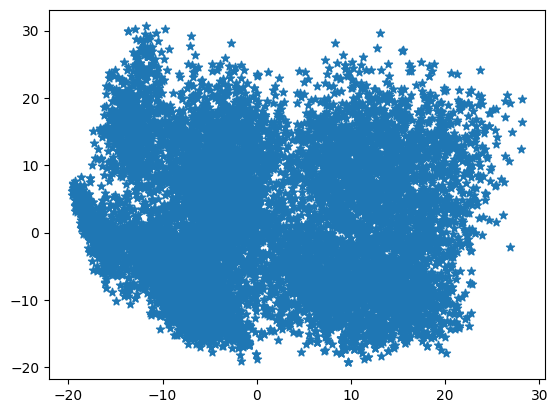

In [14]:
plt.scatter(proj_true[:, 0], proj_true[:, 1], marker="*")

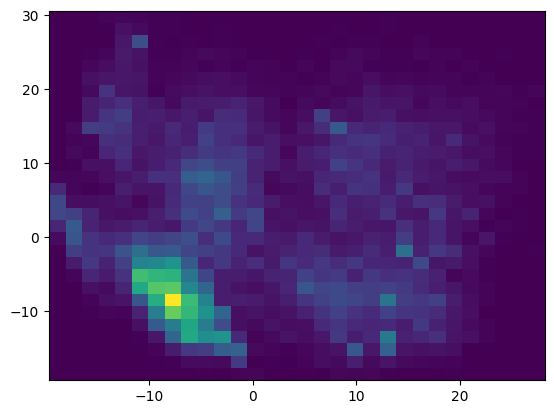

In [15]:
plt.hist2d(proj_true[:, 0], proj_true[:, 1],bins=30)
plt.show()

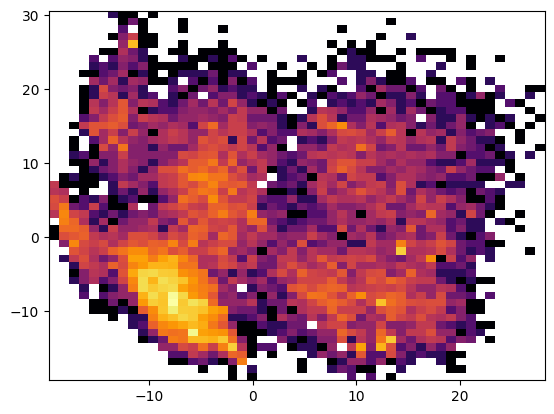

In [16]:
# Generate some test data
x = proj_true[:,0]
y = proj_true[:, 1]
from matplotlib import colors

fig, ax = plt.subplots(nrows=1, ncols=1)

#heatmap, xedges, yedges = np.histogram2d(x, y, bins=50)
#extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

#plt.clf()
#plt.imshow(heatmap.T, extent=extent, origin='lower', cmap="inferno")

ax.hist2d(x, y, bins=50, norm=colors.LogNorm(), cmap="inferno")
plt.show()

In [85]:
#fig.savefig("./figs/PCA_true_6k.png", format="png")

In [17]:
proj_potts = pca_mse.transform(msa_t)

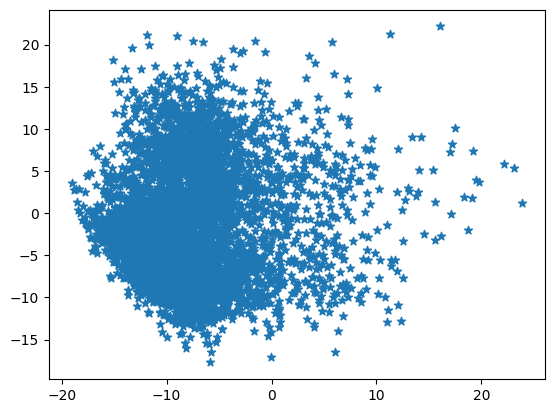

In [18]:
plt.scatter(proj_potts[:, 0], proj_potts[:, 1], marker="*")

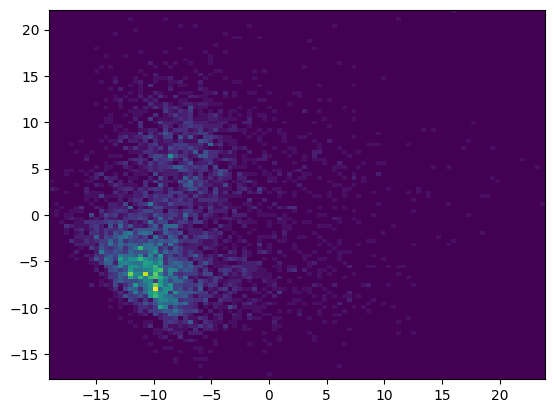

In [19]:
plt.hist2d(proj_potts[:, 0], proj_potts[:, 1],bins=100)
plt.show()

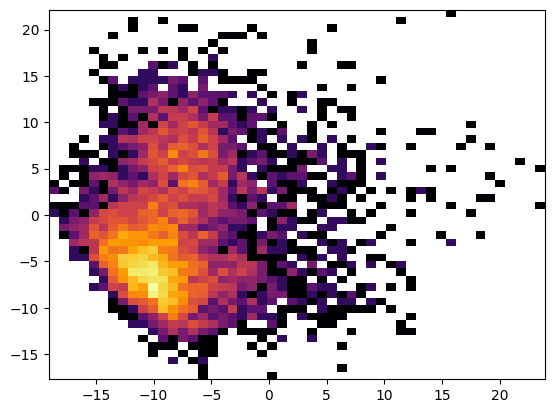

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.hist2d(proj_potts[:, 0], proj_potts[:, 1], bins=50, norm=colors.LogNorm(), cmap="inferno")
plt.show()

#heatmap, xedges, yedges = np.histogram2d(x, y, bins=50)
#extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

#plt.clf()
#plt.imshow(heatmap.T, extent=extent, origin='lower'samples_hmm_potts, cmap="inferno")
#At this point the proof is exactly the same as before, hence we just state the proposition.

In [94]:
#fig.savefig("./figs/PCA_potts_true.png", format="png")

## ESM SAMPLING + RE-ALIGNMENT

In [68]:
import pyhmmer

alphabet_hmm = pyhmmer.easel.Alphabet.amino()
alphabet_hmm

pyhmmer.easel.Alphabet.amino()

In [69]:
with pyhmmer.easel.MSAFile(fastapath, digital=True, alphabet=alphabet_hmm) as msa_file:
    msa = msa_file.read()

In [70]:
msa.name = b"YAP-HUMAN"
builder = pyhmmer.plan7.Builder(alphabet_hmm, symfrac=0.0)
background = pyhmmer.plan7.Background(alphabet_hmm)
hmm, _, _ = builder.build_msa(msa, background)

In [71]:
model, alphabet_esm = pretrained.esm_if1_gvp4_t16_142M_UR50();
model.eval();
model.to(device);

/home/luchinoprince/Dropbox/Old_OneDrive/Phd/Second_year/research/Feinauer/esm/esm/pretrained.py:174: UserWarning: Regression weights not found, predicting contacts will not produce correct results.
  warnings.warn(


In [72]:
samples_esm = []
samples_str = []
samples_hmm = []
for attempt in range(6000):
    print(f"We are at sample {attempt} out of {6000}", end="\r")
    sample = model.sample(coords, temperature=1.0)
    name = f"sample{attempt}".encode('ASCII')
    sample_dig = pyhmmer.easel.TextSequence(name = name, sequence=sample).digitize(alphabet_hmm)
    samples_hmm.append(sample_dig)
    samples_str.append(sample)
    seq_num = []
    for char in sample:
        seq_num.append(aa_index[char])
    samples_esm.append(seq_num)

/home/luchinoprince/Dropbox/Old_OneDrive/Phd/Second_year/research/Feinauer/esm/esm/inverse_folding/util.py:246: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  F.pad(torch.tensor(cd), (0, 0, 0, 0, 1, 1), value=np.inf)


### First directly project on PCA componenets

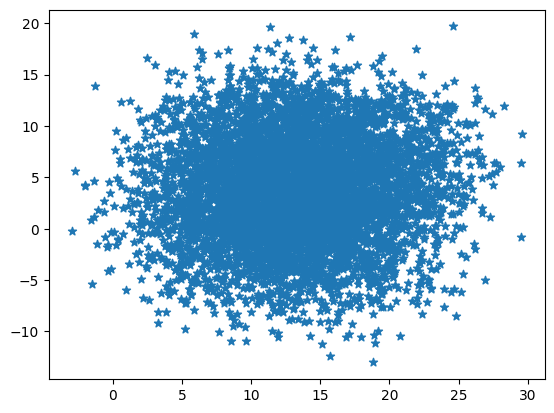

In [100]:
proj_esm = pca_mse.transform(samples_esm)
plt.scatter(proj_esm[:, 0], proj_esm[:, 1], marker="*")

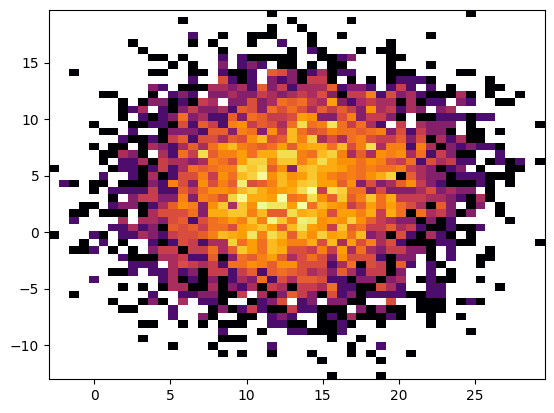

In [103]:
from matplotlib import colors
fig, ax = plt.subplots(nrows=1, ncols=1)

#heatmap, xedges, yedges = np.histogram2d(x, y, bins=50)
#extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

#plt.clf()
#plt.imshow(heatmap.T, extent=extent, origin='lower', cmap="inferno")

ax.hist2d(proj_esm[:,0], proj_esm[:,1], bins=50, norm=colors.LogNorm(), cmap="inferno")
plt.show()

In [101]:
#fig.savefig("./figs/PCA_esm_not_aligned_6k.png", format="png")

### It seems to be competely rubbish. A potential issue could be that ESM never samples gaps, which in YAP are a significant portion of the residues, and hence will also contribute to the first to PCA. To see it does not sample gaps:

/tmp/ipykernel_189453/5696061.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  F.pad(torch.tensor(cd), (0, 0, 0, 0, 1, 1), value=np.inf)


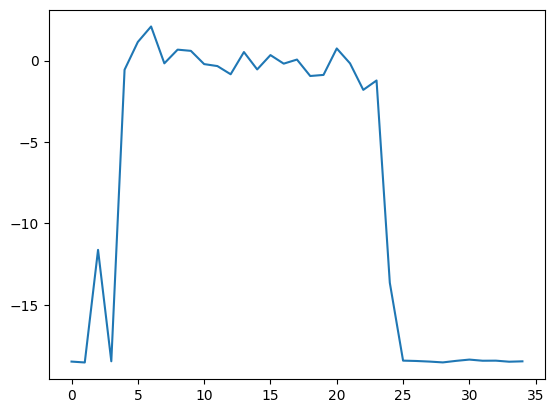

In [102]:
confidence=None
device=None
L = len(coords)
# Convert to batch format
batch_converter = CoordBatchConverter(model.decoder.dictionary)
batch_coords, confidence, _, _, padding_mask = (
    batch_converter([(coords, confidence, None)], device=device)
)
mask_idx = alphabet_esm.get_idx('<mask>')
sampled_tokens = torch.full((1, 1+N), mask_idx, dtype=int)
sampled_tokens[0, 0] = model.decoder.dictionary.get_idx('<cath>')

# Save incremental states for faster sampling
incremental_state = dict()

# Run encoder only once
encoder_out = model.encoder(batch_coords, padding_mask, confidence)

i=1
logits, _ = model.decoder(
    sampled_tokens[:, :i], 
    encoder_out,
    incremental_state=incremental_state,
)

plt.plot(logits[0,:,0].detach().numpy())

### In light of this observation, let us see if after re-aligning with a HMM trained on the true MSA solves the problems

In [73]:
samples_hmm[0].sequence

pyhmmer.easel.VectorU8([0, 17, 12, 9, 12, 8, 5, 19, 3, 8, 13, 19, 16, 8, 8, 5, 15, 17, 4, 4, 19, 2, 8, 11, 16, 11, 16, 0, 15, 18, 3, 2, 12, 14, 3, 15])

In [74]:
msa_aligned = pyhmmer.hmmer.hmmalign(hmm, samples_hmm, trim=True)
msa_aligned.alignment[1]

'--ALPAGWQEIKTKKGKTLYFDKTTNTYTKHDPR--'

In [75]:
samples_aligned_num = []
for it in range(len(msa_aligned.alignment)):
    seq_num = []
    sample = msa_aligned.alignment[it]
    for char in sample:
        seq_num.append(aa_index[char])
    samples_aligned_num.append(seq_num)

In [76]:
samples_aligned_num = torch.tensor(samples_aligned_num)

In [77]:
samples_aligned_num[0, ::]

tensor([20, 20, 12,  9, 12,  8,  5, 19,  3,  8, 13, 19, 16,  8,  8,  5, 15, 17,
         4,  4, 19,  2,  8, 11, 16, 11, 16,  0, 15, 18,  3,  2, 12, 14,  3, 15])

In [78]:
proj_esm = pca_mse.transform(samples_aligned_num)

#### Let us try re-align the aligned sequence to see if the problems with Potts are the Gaps.

In [201]:
samples_realigned = []
for i in range(len(samples_aligned_num)):
    seq_num = samples_aligned_num[i]
    seq_str = ""
    for num in seq_num:
        seq_str += aa_index_inv[num.item()]
    name = f"sample{i}".encode('ASCII')
    sample_dig = pyhmmer.easel.TextSequence(name = name, sequence=seq_str).digitize(alphabet_hmm)
    samples_realigned.append(sample_dig)

In [202]:
samples_realigned[0].sequence

pyhmmer.easel.VectorU8([20, 0, 12, 0, 12, 15, 5, 19, 17, 18, 3, 8, 16, 15, 16, 5, 8, 15, 17, 19, 19, 11, 16, 16, 16, 11, 16, 18, 15, 18, 3, 2, 12, 14, 20, 20])

In [203]:
samples_aligned_num[0]

tensor([20,  0, 12,  0, 12, 15,  5, 19, 17, 18,  3,  8, 16, 15, 16,  5,  8, 15,
        17, 19, 19, 11, 16, 16, 16, 11, 16, 18, 15, 18,  3,  2, 12, 14, 20, 20])

In [209]:
msa_aligned_2 = pyhmmer.hmmer.hmmalign(hmm, samples_realigned, trim=True)
msa_aligned_2.alignment[0]

'-APAPSGYVWEKTSTGKSVYYNTTTNTWSWEDPR--'

In [210]:
aux = samples_aligned_num[0]
transl = ""
for el in aux:
    transl += aa_index_inv[el.item()]
transl

'-APAPSGYVWEKTSTGKSVYYNTTTNTWSWEDPR--'

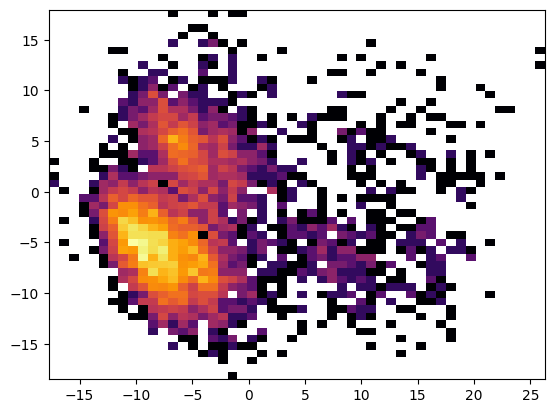

In [79]:
from matplotlib import colors
fig, ax = plt.subplots(nrows=1, ncols=1)

#heatmap, xedges, yedges = np.histogram2d(x, y, bins=50)
#extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

#plt.clf()
#plt.imshow(heatmap.T, extent=extent, origin='lower', cmap="inferno")

ax.hist2d(proj_esm[:,0], proj_esm[:,1], bins=50, norm=colors.LogNorm(), cmap="inferno")
plt.show()

In [95]:
#fig.savefig("PCA_esm_realigned_6k.png", format="png")

## Now let is move to analysis of the single-site frequencies.
#### Given what we have observed, we will re-align the sequences generated by ESM, as we can expect that the single site frequencies for the non-aligned ones will be very bad

In [104]:
def get_embedding(q):

    embedding = torch.nn.Embedding(q+1, q).requires_grad_(False)
    embedding.weight.data.zero_()

    embedding.weight[:q, :q] = torch.eye(q)

    return embedding
embeddings = get_embedding(q)

In [105]:
native_seq

'DVPLPAGWEMAKTSSGQRYFLNHIDQTTTWQDPRKA'

In [106]:
samples_esm_emb = embeddings(samples_aligned_num)

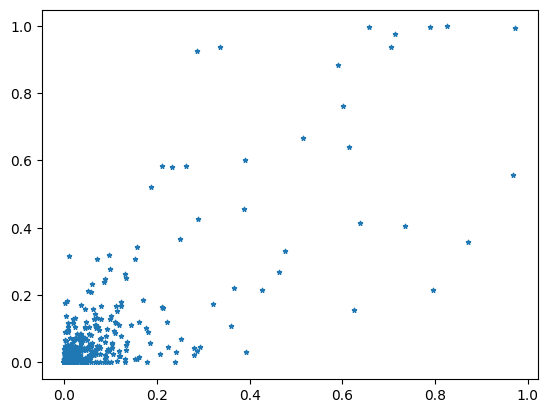

In [115]:
M,N = msa_true.shape 
M_esm = samples_aligned_num.shape[0]
fi_esm = torch.sum(samples_esm_emb, dim=0)/M_esm
msa_true_emb = embeddings(msa_true)
fi_true=torch.sum(msa_true_emb, dim=0)/M
plt.scatter(fi_true.flatten(), fi_esm.flatten(), marker="*", s=10)

### Now we move to the single site frequencies for Potts.

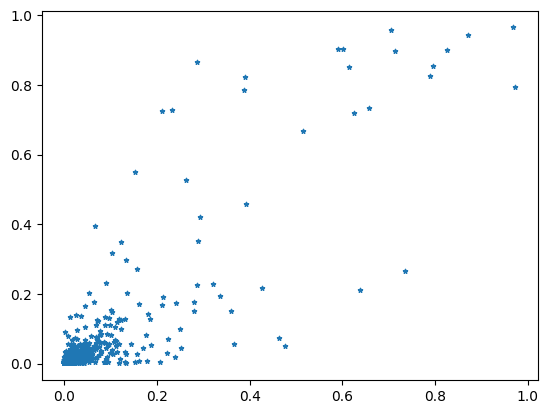

In [118]:
M_p, N = msa_t.shape
msa_t_emb = embeddings(msa_t)
fi_potts = torch.sum(msa_t_emb, dim=0)/M_p
plt.scatter(fi_true.flatten(), fi_potts.flatten(), marker="*", s=10)

## Now two-sites frequencies

In [141]:
def compute_fij(msa, q):
    """
    Compute covariance matrix of a given MSA having q different amino acids
    """
    M, N = msa.shape

    # One hot encode classes and reshape to create data matrix
    D = torch.flatten(one_hot(msa, num_classes=q), start_dim=1).to(torch.float32)

    # Remove one amino acid
    D = D.view(M, N, q)[:, :, :q-1].flatten(1)

    # Compute bivariate frequencies
    bivariate_freqs = D.T @ D / M
    
    # Compute product of univariate frequencies
    #univariate_freqs = torch.diagonal(bivariate_freqs).view(N*(q-1), 1) @ torch.diagonal(bivariate_freqs).view(1, N*(q-1))

    return bivariate_freqs #- univariate_freqs

In [149]:
fij_potts = compute_fij(msa_t, q)
fij_true = compute_fij(msa_true, q)
fij_esm = compute_fij(samples_aligned_num, q)

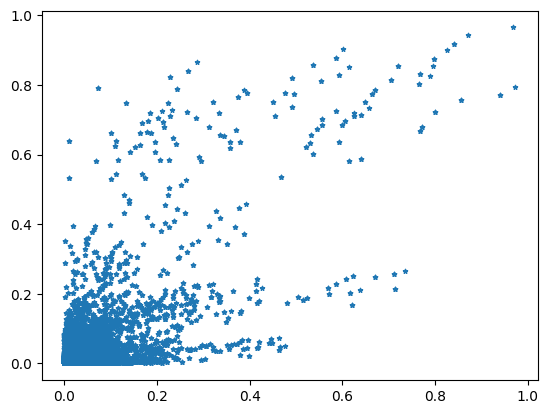

In [154]:
plt.scatter(fij_true.flatten(), fij_potts.flatten(), marker="*", s=10)

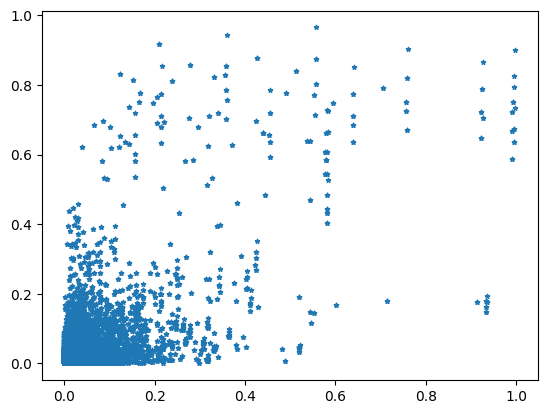

In [155]:
plt.scatter(fij_esm.flatten(), fij_potts.flatten(), marker="*", s=10)

## Test asked by Barth: distribution of distances between generated samples and between generated sample and true samples.

### We begin by doing an histogram of the scores between samples generated by esm and then realigned

In [124]:
distances = []
M_esm = len(samples_esm)
for i in range(M_esm):
    for j in range(i+1, M_esm):
        distances.append(torch.sum(samples_aligned_num[i,:] == samples_aligned_num[j,:]).item()/N)


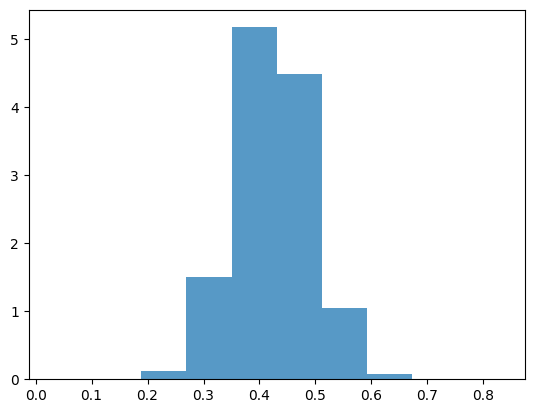

In [128]:
plt.hist(distances, density=True, alpha=0.75);

### I then look at the histogram of the scores between true sequences of the MSA and esm sequences after being re-aligned

In [131]:
## I subsample both the esm sequences and the true ones to make the computation faster
distances_true = []
for i in range(2000):
    for j in range(2000):
        distances_true.append(torch.sum(samples_aligned_num[i,:] == msa_true[j,:]).item()/N)

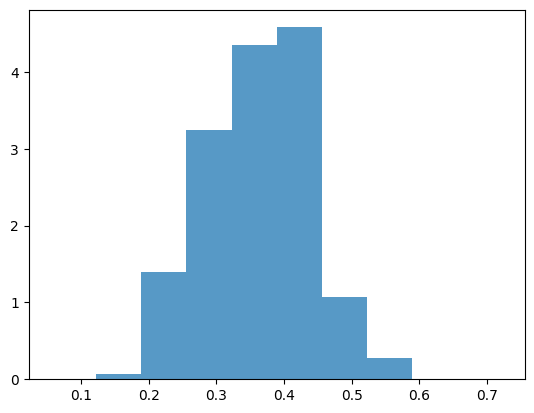

In [132]:
plt.hist(distances_true, density=True, alpha=0.75);

### Histrogram of scores between sequences generated by the Potts model

In [133]:
M_potts = msa_t.shape[0]
distances_potts = []
for i in range(M_potts//10):
    for j in range(i+1, M_potts//10):
        distances_potts.append(torch.sum(msa_t[i,:] == msa_t[j,:]).item()/N)

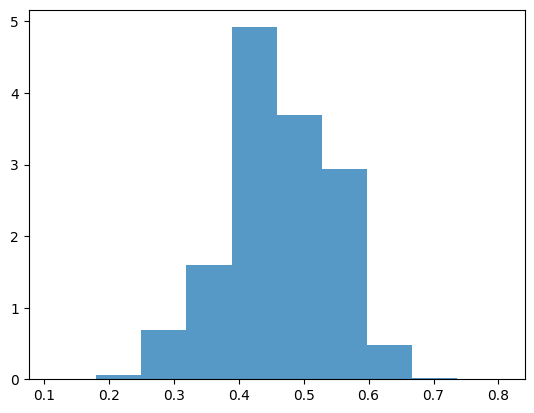

In [134]:
plt.hist(distances_potts, density=True, alpha=0.75);

### Histogram of scores between sequences generated by the Potts model and true sequences.

In [135]:
M_potts = msa_t.shape[0]
distances_potts_true = []
for i in range(M_potts//10):
    for j in range(M//10):
        distances_potts_true.append(torch.sum(msa_t[i,:] == msa_true[j,:]).item()/N)

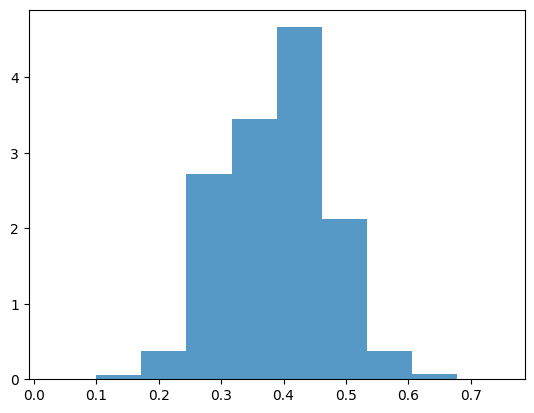

In [136]:
plt.hist(distances_potts_true, density=True, alpha=0.75);